% Backlog Rate: 1.5708274894810659 2.7564553452195275
mean_handling_time_minute: 5.063380223745511 6.07957398037439
median_handling_time_minute: 2.6806987166666665 2.768214148305861
mean_first_touch_minute: 1027.0937149062318 1118.2780965754994
median_first_touch_minute: 219.80734669583333 272.38194190334247
mean_last_touch_minute: 1953.8360130100073 2183.7139723885716
median_last_touch_minute: 501.0797106333333 572.6898844796041
Distribution of Inconsistent Decision


OPS_DECISION                  FINAL_STATE     
OPS_WAITING                   CLOSED              68240
OPS_VERIFICATION_TEAM_CHANGE  CLOSED                961
OPS_UNASSIGN                  CLOSED                750
OPS_VERIFICATION_TEAM_CHANGE  REVIEW_NEEDED         230
OPS_REVIEW_PAUSE              CLOSED                171
OPS_WAITING                   APPROVED              102
                              UPDATED                86
OPS_VERIFICATION_TEAM_CHANGE  WAITING                17
OPS_UNASSIGN                  WAITING                11
OPS_VERIFICATION_TEAM_CHANGE  APPROVED               11
OPS_WAITING                   REVIEW_NEEDED           9
OPS_UNASSIGN                  REVIEW_NEEDED           8
OPS_WAITING                   NO_REVIEW_NEEDED        5
OPS_VERIFICATION_TEAM_CHANGE  REJECTED                4
OPS_WAITING                   REJECTED                3
                              REVIEW                  3
OPS_UNASSIGN                  APPROVED                3
O

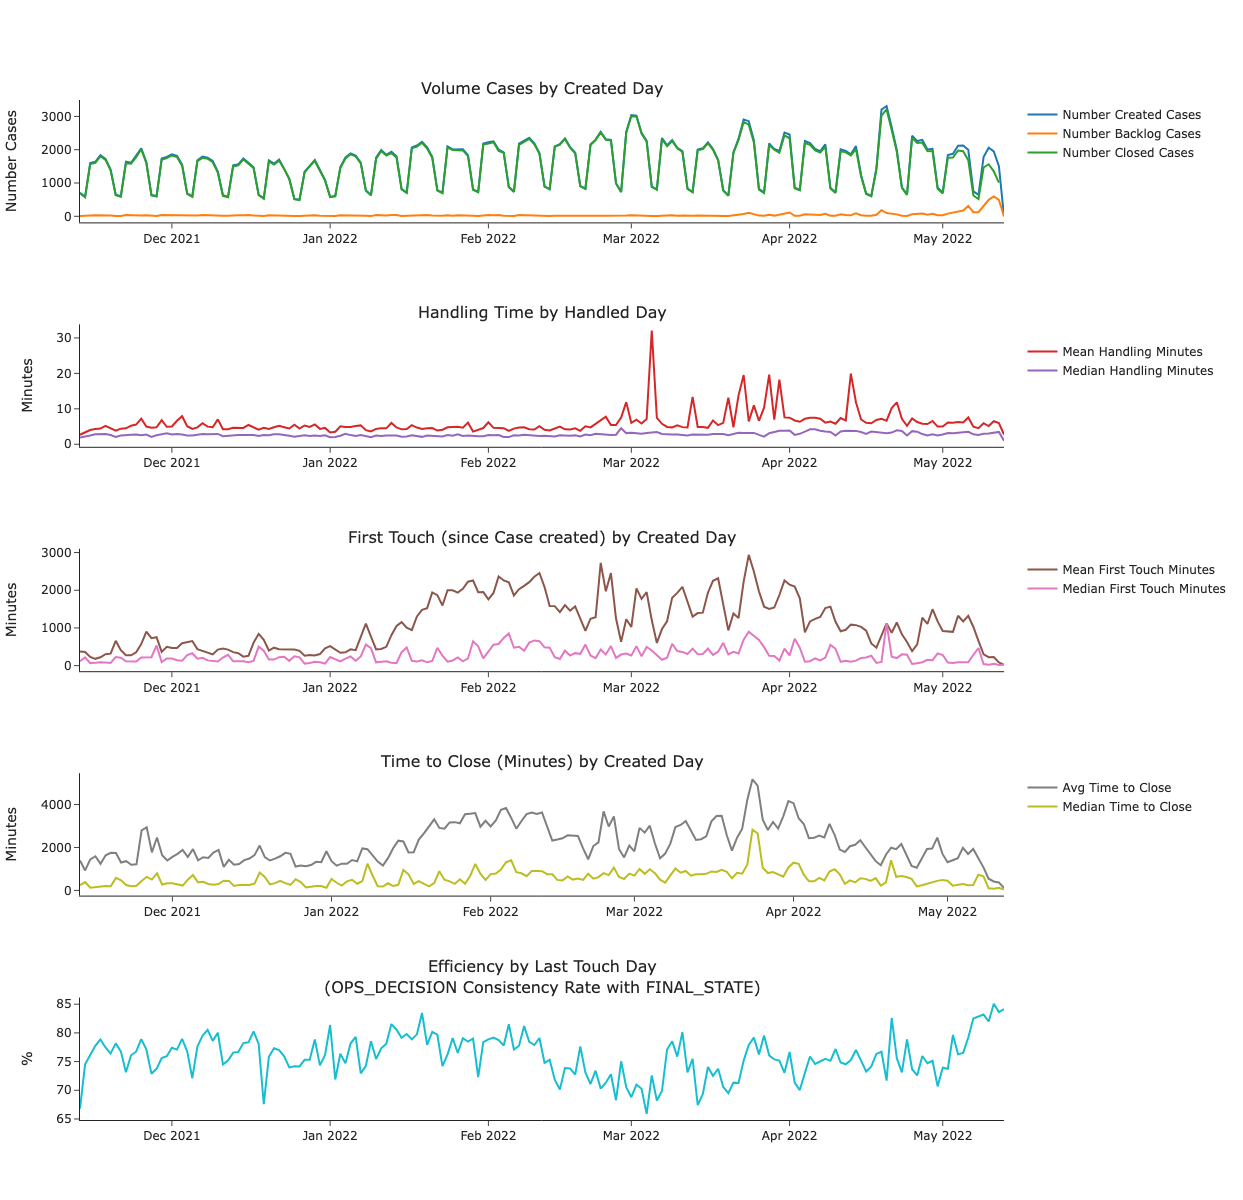

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
import plotly.express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data.csv")
for c in ["HANDLING_TIME_START", "HANDLING_TIME_END", "CASE_CREATED_TIME"]:
    df[c] = pd.to_datetime(df[c])
    df[f"{c}_date"] = pd.to_datetime(df[c].dt.strftime('%Y-%m-%d'))
    df[f"{c}_month"] = df[c].dt.strftime('%Y-%m')
max_day = df['HANDLING_TIME_END_date'].max()+pd.Timedelta(days=1)

# Define close_state
close_state = [
               'APPROVED', 
               'CLOSED', 'REJECTED', 'NO_REVIEW_NEEDED'
]

# Remove a record for data quality where HANDLING_TIME_END < HANDLING_TIME_END
df = df[df.HANDLING_TIME_END > df.HANDLING_TIME_START]
# preprocessing data
df["CASE_TYPE"] = df["CASE_TYPE"].map({"TYPE_ONE": "TYPE_1",
                                       "TYPE_TWO": "TYPE_2",
                                       "TYPE_THREE": "TYPE_3"
                                                        })
# Calculate handling time (minutes)
df['handling_time_minute'] = (df['HANDLING_TIME_END'] - df['HANDLING_TIME_START']).dt.total_seconds()/60

# Aggregation Case Characteristic 
agg_case = df.groupby("CASE_ID").agg({"CASE_CREATED_TIME": "min",
                                      "HANDLING_TIME_START": [lambda x: x.nunique(), "min"],
                                      "HANDLING_TIME_END": [lambda x: x.nunique(), "max"],
                                      "ACTOR_ID": lambda x: x.nunique(),
                                      "PROCESSING_ID": lambda x: x.nunique()
                                     })
agg_case.columns = ["CASE_CREATED_TIME", 
                    "NUMBER_HANDLE_START", "HANDLING_TIME_START", 
                    "NUMBER_HANDLE_END", "HANDLING_TIME_END", "N_ACTOR", "N_PROCESSING"]
for c in ["HANDLING_TIME_START", "HANDLING_TIME_END", "CASE_CREATED_TIME"]:
    agg_case[c] = pd.to_datetime(agg_case[c])
    agg_case[f"{c}_date"] = pd.to_datetime(agg_case[c].dt.strftime('%Y-%m-%d'))
    agg_case[f"{c}_month"] = agg_case[c].dt.strftime('%Y-%m')

# Merge with df on latest handling time end for final OPS decision and states
agg_case = agg_case.merge(df[["CASE_ID", 'CASE_CREATED_TIME', 'HANDLING_TIME_END','OPS_DECISION', 'FINAL_STATE']],
                          on=["CASE_ID", 'CASE_CREATED_TIME', 'HANDLING_TIME_END'],
                          how='inner')
agg_case["first_touch_minute"] = (agg_case["HANDLING_TIME_START"] - agg_case["CASE_CREATED_TIME"]).dt.total_seconds()/60
agg_case["last_touch_minute"] = (agg_case["HANDLING_TIME_END"] - agg_case["CASE_CREATED_TIME"]).dt.total_seconds()/60


backlog = df[~df['FINAL_STATE'].isin(close_state)].groupby('CASE_CREATED_TIME_date').agg({"CASE_ID": lambda x: x.nunique()}).reset_index()
closed = df[df['FINAL_STATE'].isin(close_state)].groupby('CASE_CREATED_TIME_date').agg({"CASE_ID": lambda x: x.nunique()}).reset_index()
closed_case_list = df[df['FINAL_STATE'].isin(close_state)].CASE_ID.unique()
# Analyze the trend/volume of case by date
fig = make_subplots(rows=5, cols=1,
                    subplot_titles=("Volume Cases by Created Day", 
                                    "Handling Time by Handled Day", 
                                    "First Touch (since Case created) by Created Day", 
                                    'Time to Close (Minutes) by Created Day',
                                    "Efficiency by Last Touch Day<br>(OPS_DECISION Consistency Rate with FINAL_STATE)"),
                    vertical_spacing = 0.1
                   )
volume_df = df.groupby('CASE_CREATED_TIME_date').agg({'CASE_ID': lambda x: x.nunique(),
                                          'CUSTOMER_ID': lambda x: x.nunique()
                                         }).reset_index()
print('% Backlog Rate:', 100*backlog.CASE_ID.median() / volume_df.CASE_ID.median(), 100*backlog.CASE_ID.mean() / volume_df.CASE_ID.mean())
# Adding volume trace to plot
fig.add_trace(
    go.Scatter(x=volume_df['CASE_CREATED_TIME_date'], y=volume_df['CASE_ID'], name=f"Number Created Cases", legendgroup = '1'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=backlog['CASE_CREATED_TIME_date'], y=backlog['CASE_ID'], name=f"Number Backlog Cases", legendgroup = '1'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=closed['CASE_CREATED_TIME_date'], y=closed['CASE_ID'], name=f"Number Closed Cases", legendgroup = '1'),
    row=1, col=1
)

# Analyze the trend by handling time
# Handling time should be aggregated based on HANDLING_TIME_START
handle_time_df = df.groupby('HANDLING_TIME_START_date').agg({'handling_time_minute': ["mean", "median"]}).reset_index()
handle_time_df.columns = ["HANDLING_TIME_START_date", "mean_handling_time_minute", "median_handling_time_minute"]
print('mean_handling_time_minute:', handle_time_df.mean_handling_time_minute.median() , handle_time_df.mean_handling_time_minute.mean())
print('median_handling_time_minute:', handle_time_df.median_handling_time_minute.median() , handle_time_df.median_handling_time_minute.mean())
# Adding trace
fig.add_trace(
    go.Scatter(x=handle_time_df['HANDLING_TIME_START_date'], y=handle_time_df['mean_handling_time_minute'], 
               name=f"Mean Handling Minutes", legendgroup = '2'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=handle_time_df['HANDLING_TIME_START_date'], y=handle_time_df['median_handling_time_minute'], 
               name=f"Median Handling Minutes", legendgroup = '2'),
    row=2, col=1
)

# Analyze the trend by first touch time
first_touch_time_df = agg_case.groupby('CASE_CREATED_TIME_date').agg({'first_touch_minute': ["mean", "median"]}).reset_index()
first_touch_time_df.columns = ['CASE_CREATED_TIME_date', 'mean_first_touch_minute', 'median_first_touch_minute']
print('mean_first_touch_minute:', first_touch_time_df.mean_first_touch_minute.median() , first_touch_time_df.mean_first_touch_minute.mean())
print('median_first_touch_minute:', first_touch_time_df.median_first_touch_minute.median() , first_touch_time_df.median_first_touch_minute.mean())
# Adding trace
fig.add_trace(
    go.Scatter(x=first_touch_time_df['CASE_CREATED_TIME_date'], y=first_touch_time_df['mean_first_touch_minute'], 
               name=f"Mean First Touch Minutes", legendgroup = '3'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=first_touch_time_df['CASE_CREATED_TIME_date'], y=first_touch_time_df['median_first_touch_minute'], 
               name=f"Median First Touch Minutes", legendgroup = '3'),
    row=3, col=1
)

# Analyze the trend by last touch time for all cases
last_touch_time_df = agg_case.groupby('CASE_CREATED_TIME_date').agg({'last_touch_minute': ["mean",                          
                                                                                           "median"]}).reset_index()
last_touch_time_df.columns = ['CASE_CREATED_TIME_date', 'mean_last_touch_minute', 'median_last_touch_minute']

# Analyze the trend by last touch time for closed cases
last_touch_time_close_df = agg_case[agg_case.CASE_ID.isin(closed_case_list)].groupby('CASE_CREATED_TIME_date').agg({'last_touch_minute': ["mean",                          
                                                                                                                                    "median"]}).reset_index()
last_touch_time_close_df.columns = ['CASE_CREATED_TIME_date', 'mean_last_touch_minute', 'median_last_touch_minute']
# last_touch_time_df = last_touch_time_df[last_touch_time_df]
print('mean_last_touch_minute:', last_touch_time_close_df.mean_last_touch_minute.median() , last_touch_time_close_df.mean_last_touch_minute.mean())
print('median_last_touch_minute:', last_touch_time_close_df.median_last_touch_minute.median() , last_touch_time_close_df.median_last_touch_minute.mean())
# Adding trace
fig.add_trace(
    go.Scatter(x=last_touch_time_close_df['CASE_CREATED_TIME_date'], 
               y=last_touch_time_close_df['mean_last_touch_minute'], 
               name=f"Avg Time to Close",
               legendgroup = '4'
              ),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=last_touch_time_close_df['CASE_CREATED_TIME_date'], 
               y=last_touch_time_close_df['median_last_touch_minute'],
               name=f"Median Time to Close",
               legendgroup = '4'
              ),
    row=4, col=1
)
# fig.add_trace(
#     go.Scatter(x=last_touch_time_close_df['CASE_CREATED_TIME_date'], y=last_touch_time_close_df['median_last_touch_minute']
#                ,name=f"Median Time to Close (Minutes)"
#                ,showlegend=True 
#               ),
#     row=4, col=1
# )
# Now analyze consitency, the last actor or operator decision (column OPS_DECISION at last handling time end) 
# must be consistent with final state decision (column FINAL_STATE)
# This reflects the quality of decision


agg_case["consistency"] = 0
agg_case.loc[(agg_case.OPS_DECISION == 'OPS_CLOSE') & (agg_case.FINAL_STATE == 'CLOSED'), "consistency"] = 1
agg_case.loc[(agg_case.OPS_DECISION == 'OPS_WAITING') & (agg_case.FINAL_STATE == 'WAITING'), "consistency"] = 1
agg_case.loc[(agg_case.OPS_DECISION == 'OPS_NO_REVIEW_NEEDED') & (agg_case.FINAL_STATE == 'NO_REVIEW_NEEDED'), "consistency"] = 1
agg_case.loc[(agg_case.OPS_DECISION == 'OPS_REVIEW_PAUSE') & (agg_case.FINAL_STATE == 'REVIEW_PAUSED'), "consistency"] = 1
agg_case.loc[(agg_case.OPS_DECISION == 'OPS_APPROVE') & (agg_case.FINAL_STATE == 'APPROVED'), "consistency"] = 1
agg_case.loc[(agg_case.OPS_DECISION == 'OPS_REJECT') & (agg_case.FINAL_STATE == 'REJECTED'), "consistency"] = 1
print("Distribution of Inconsistent Decision")
display(agg_case[agg_case.consistency != 1].groupby(["OPS_DECISION", "FINAL_STATE"])["CASE_ID"].count().sort_values(ascending=False))

# Decision comparison should be based on HANDLING_TIME_END_date, rather than created date of a case
decision_date = agg_case.groupby("HANDLING_TIME_END_date").agg({"CASE_ID": lambda x: x.nunique()}).reset_index()
# filtering consistent decision
consistent_df = agg_case[agg_case.consistency == 1].groupby("HANDLING_TIME_END_date").agg({"CASE_ID": lambda x: x.nunique()}).reset_index()
# Agg by date to calculate the rate
decision_date = decision_date.merge(consistent_df,
                                    how="left", 
                                    on="HANDLING_TIME_END_date", 
                                    suffixes=("_all","_consistent"))
decision_date = decision_date.sort_values(by="HANDLING_TIME_END_date")
decision_date["consistent_rate"] = 100*decision_date["CASE_ID_consistent"] / decision_date["CASE_ID_all"]
# Now adding new trace to plot
fig.add_trace(
    go.Scatter(x=decision_date['HANDLING_TIME_END_date'], y=decision_date['consistent_rate'], name=f"Consistency Rate",showlegend=False),
    row=5, col=1
)

fig.update_layout(width=1200, height=1200, template='simple_white', legend_tracegroupgap=180)
fig.update_yaxes(title_text="Number Cases", row=1, col=1)
fig.update_yaxes(title_text="Minutes", row=2, col=1)
fig.update_yaxes(title_text="Minutes", row=3, col=1)
fig.update_yaxes(title_text="Minutes", row=4, col=1)
fig.update_yaxes(title_text="%", row=5, col=1)
# Show the plot
fig.show()

CASE_ID    294291
dtype: int64
                           CASE_ID
first_touch_minute_label          
0-3h                      0.492472
3-12h                     0.207142
12-24h                    0.121791
24-48h                    0.057888
>48h                      0.120707
CASE_ID    286193
dtype: int64
                          CASE_ID
last_touch_minute_label          
0-3h                     0.372783
3-12h                    0.188310
12-24h                   0.131887
24-48h                   0.085600
>48h                     0.221421
CASE_ID    8097
dtype: int64
                    CASE_ID
age_label                  
<1 week            0.304063
1-2 weeks          0.080647
2 weeks - 1 month  0.116833
1 - 2 months       0.151785
2 - 3 months       0.061875
> 3 months         0.284797


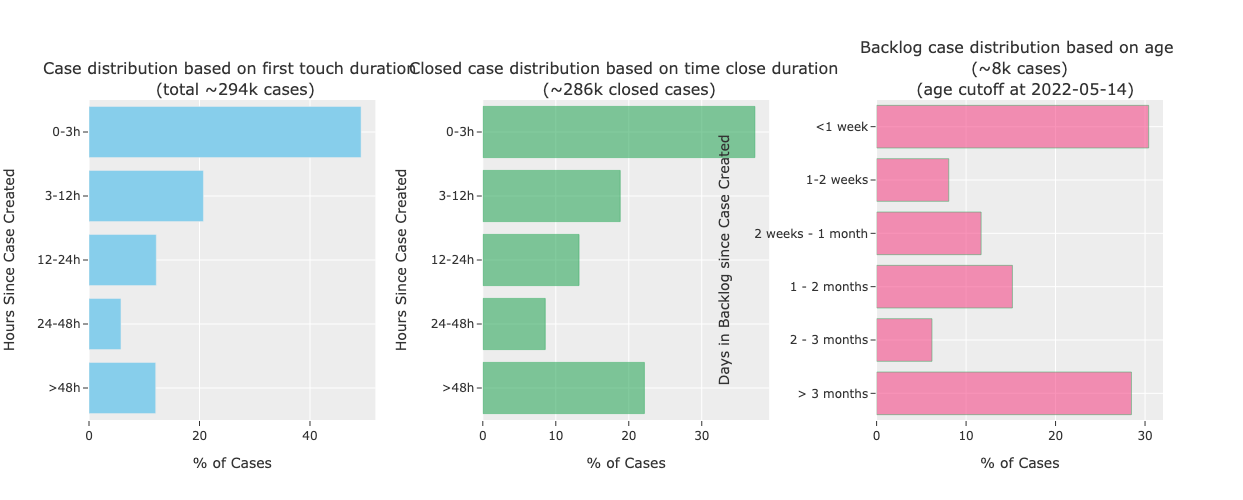

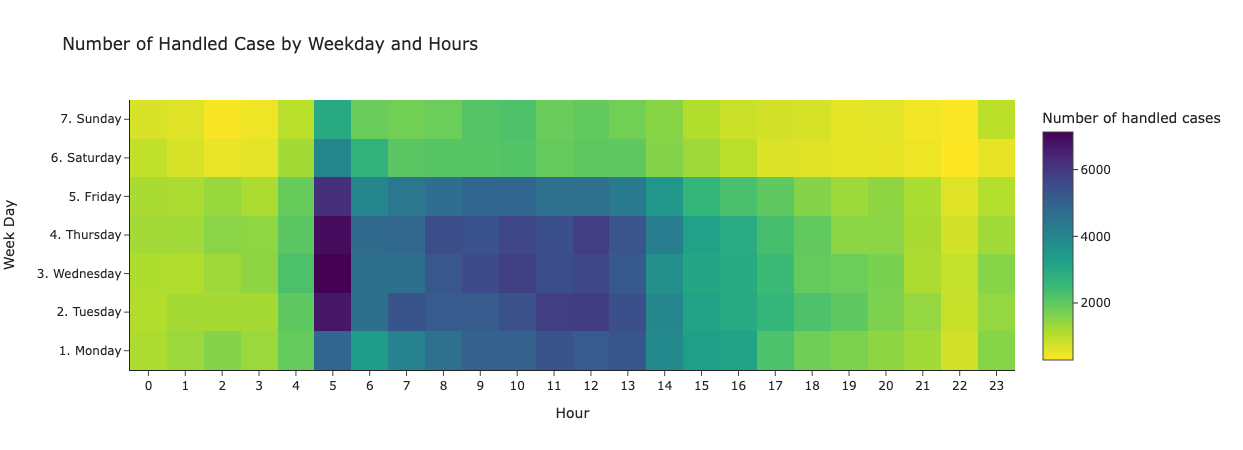

In [2]:
# Aggregation Case Characteristic 
agg_case = df.groupby("CASE_ID").agg({"CASE_CREATED_TIME": "min",
                                      "HANDLING_TIME_START": [lambda x: x.nunique(), "min"],
                                      "HANDLING_TIME_END": [lambda x: x.nunique(), "max"],
                                      "ACTOR_ID": lambda x: x.nunique(),
                                      "PROCESSING_ID": lambda x: x.nunique()
                                     })
agg_case.columns = ["CASE_CREATED_TIME", 
                    "NUMBER_HANDLE_START", "HANDLING_TIME_START", 
                    "NUMBER_HANDLE_END", "HANDLING_TIME_END", "N_ACTOR", "N_PROCESSING"]
for c in ["HANDLING_TIME_START", "HANDLING_TIME_END", "CASE_CREATED_TIME"]:
    agg_case[c] = pd.to_datetime(agg_case[c])
    agg_case[f"{c}_date"] = pd.to_datetime(agg_case[c].dt.strftime('%Y-%m-%d'))
    agg_case[f"{c}_month"] = agg_case[c].dt.strftime('%Y-%m')

# Merge with df on latest handling time end for final OPS decision and states
agg_case = agg_case.merge(df[["CASE_ID", 'CASE_CREATED_TIME', 'HANDLING_TIME_END','OPS_DECISION', 'FINAL_STATE']],
                          on=["CASE_ID", 'CASE_CREATED_TIME', 'HANDLING_TIME_END'],
                          how='inner')
agg_case["first_touch_minute"] = (agg_case["HANDLING_TIME_START"] - agg_case["CASE_CREATED_TIME"]).dt.total_seconds()/60
agg_case["last_touch_minute"] = (agg_case["HANDLING_TIME_END"] - agg_case["CASE_CREATED_TIME"]).dt.total_seconds()/60

agg_case["first_touch_minute_label"]  = pd.cut(agg_case['first_touch_minute'],
                                              bins=[0, 60*3, 60*12, 60*24, 60*48, float('inf')], 
                                              labels=['0-3h', '3-12h', '12-24h', '24-48h', '>48h']
                                              )
agg_case_first_touch_minute = agg_case.groupby('first_touch_minute_label').agg({'CASE_ID': lambda x: x.nunique()})
print(agg_case_first_touch_minute.sum())
print(agg_case_first_touch_minute/agg_case_first_touch_minute.sum())

agg_case["last_touch_minute_label"]  = pd.cut(agg_case['last_touch_minute'],
                                              bins=[0, 60*3, 60*12, 60*24, 60*48, float('inf')], 
                                              labels=['0-3h', '3-12h', '12-24h', '24-48h', '>48h']
                                             )
agg_close_case_atc = agg_case[agg_case.CASE_ID.isin(closed_case_list)].groupby('last_touch_minute_label').agg({'CASE_ID': lambda x: x.nunique()})
print(agg_close_case_atc.sum())
print(agg_close_case_atc/agg_close_case_atc.sum())

agg_case["age"]  = (max_day - agg_case["CASE_CREATED_TIME"]).dt.days
agg_case["age_label"]  = pd.cut(agg_case['age'],
       bins=[0, 7, 14, 30, 60, 90, float('inf')], 
       labels=['<1 week', '1-2 weeks', '2 weeks - 1 month', '1 - 2 months', '2 - 3 months', '> 3 months']
)
agg_backlog_age = agg_case[~agg_case.CASE_ID.isin(closed_case_list)].groupby('age_label').agg({'CASE_ID': lambda x: x.nunique()})
print(agg_backlog_age.sum())
print(agg_backlog_age/agg_backlog_age.sum())

plot_df_1 = 100*agg_case_first_touch_minute/agg_case_first_touch_minute.sum()#.reset_index()
plot_df_2 = 100*agg_close_case_atc/agg_close_case_atc.sum()#.reset_index()
plot_df_3 = 100*agg_backlog_age/agg_backlog_age.sum()#.reset_index()

plot_df_1 = plot_df_1.reset_index()
plot_df_2 = plot_df_2.reset_index()[::-1]
plot_df_3 = plot_df_3.reset_index()[::-1]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=(f"Case distribution based on first touch duration <br> (total ~294k cases)", 
                                    f"Closed case distribution based on time close duration <br> (~286k closed cases)", 
                                    f"Backlog case distribution based on age <br> (~8k cases) <br>  (age cutoff at 2022-05-14)"),
                    horizontal_spacing = 0.1
                   )
# Create horizontal bar plot
fig.add_traces(go.Bar(
                y=plot_df_1["first_touch_minute_label"],  # Values
                x=plot_df_1["CASE_ID"],  # Categories
                orientation='h', 
                marker=dict(color='skyblue', line=dict(width=0.5)),
        showlegend=False
),
    rows=1, cols=1
)

# bar_colors = ["skyblue" for column in plot_df_1.columns]
fig.add_traces(go.Bar(
                y=plot_df_2["last_touch_minute_label"],  # Values
                x=plot_df_2["CASE_ID"],  # Categories
                orientation='h', 
                    marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=0.5),
    ),    showlegend=False
),
    rows=1, cols=2
)

fig.add_traces(go.Bar(
                y=plot_df_3["age_label"],  # Values
                x=plot_df_3["CASE_ID"],  # Categories
                orientation='h', 
                    marker=dict(
        color='rgba(246, 78, 139, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=0.5),
    ),
    showlegend=False
),
    rows=1, cols=3
)

# Update layout
fig.update_layout(
    # title='Autobid Usage Patterns for ~2k sellers <br> after X months (X >= 3) of first use VBP from 03/2023 - 02/2024 ',
    xaxis_title='(%) of Unique Seller Count',
    yaxis_title='',
    yaxis=dict(autorange="reversed"),  # Reverse the y-axis
    width=1600,
    height=500,
    template="ggplot2"
)

# fig.update_layout(width=1200, height=1200, template='simple_white', legend_tracegroupgap=180)
fig.update_yaxes(title_text="Hours Since Case Created", row=1, col=1)
fig.update_xaxes(title_text="% of Cases", row=1, col=1)
fig.update_yaxes(title_text="Hours Since Case Created", row=1, col=2)
fig.update_xaxes(title_text="% of Cases", row=1, col=2)
fig.update_yaxes(title_text="Days in Backlog since Case Created", row=1, col=3)
fig.update_xaxes(title_text="% of Cases", row=1, col=3)
# Show plot
fig.show()

df_wd = df[["HANDLING_TIME_START", "CASE_ID"]].copy()
df_wd["HANDLING_TIME_HOUR"] = df_wd["HANDLING_TIME_START"].dt.hour
df_wd["HANDLING_TIME_WEEKDAY"] = df_wd["HANDLING_TIME_START"].dt.weekday
df_wd["HANDLING_TIME_WEEKDAY"] =  df_wd["HANDLING_TIME_WEEKDAY"].map({
    0: '1. Monday',
    1: '2. Tuesday',
    2: '3. Wednesday',
    3: '4. Thursday',
    4: '5. Friday',
    5: '6. Saturday',
    6: '7. Sunday'
})
case_by_time = df_wd.groupby(['HANDLING_TIME_HOUR', 'HANDLING_TIME_WEEKDAY']).agg({'CASE_ID': lambda x: x.nunique()}).reset_index()

heatmap_data = case_by_time.pivot(columns='HANDLING_TIME_HOUR', index='HANDLING_TIME_WEEKDAY', values="CASE_ID")
# heatmap_data = heatmap_data.reindex(sorted(heatmap_data.index))
# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns.astype(str),
    y=heatmap_data.index.astype(str),
    colorscale='Viridis_r',  # You can choose any colorscale
    colorbar=dict(title='Number of handled cases'),
))

# Update layout
fig.update_layout(
    title=f'Number of Handled Case by Weekday and Hours',
    xaxis=dict(title='Hour'),
    yaxis=dict(title='Week Day'),
    width=900,
    height=450,
    template="simple_white"
)

# Show plot
fig.show()

### Aggregation Case Characteristic by ACTOR_ID, CASE_TYPE

In [3]:
agg_actor = df.groupby(["ACTOR_ID", "CASE_ID"]).agg({"CASE_CREATED_TIME": "min",
                                                 "HANDLING_TIME_START": [lambda x: x.nunique(), "min"],
                                                 "HANDLING_TIME_END": [lambda x: x.nunique(), "max"],
                                                 "PROCESSING_ID": lambda x: x.nunique()
                                     })

agg_actor.columns = ["CASE_CREATED_TIME", 
                     "NUMBER_HANDLE_START", "HANDLING_TIME_START", 
                     "NUMBER_HANDLE_END", "HANDLING_TIME_END", "N_PROCESSING"]

for c in ["HANDLING_TIME_START", "HANDLING_TIME_END", "CASE_CREATED_TIME"]:
    agg_actor[c] = pd.to_datetime(agg_actor[c])
    agg_actor[f"{c}_date"] = pd.to_datetime(agg_actor[c].dt.strftime('%Y-%m-%d'))
    agg_actor[f"{c}_month"] = agg_actor[c].dt.strftime('%Y-%m')
agg_actor = agg_actor.reset_index()
# Merge with df on latest handling time end for final OPS decision and states
agg_actor = agg_actor.merge(df[["ACTOR_ID", "CASE_ID", "CASE_TYPE", 'CASE_CREATED_TIME', 'HANDLING_TIME_START','HANDLING_TIME_END','OPS_DECISION', 'FINAL_STATE']],
                            on=["ACTOR_ID", "CASE_ID", 'CASE_CREATED_TIME', 'HANDLING_TIME_START', 'HANDLING_TIME_END'],
                            how='inner')
agg_actor["first_touch_minute"] = (agg_actor["HANDLING_TIME_START"] - agg_actor["CASE_CREATED_TIME"]).dt.total_seconds()/60
agg_actor["last_touch_minute"] = (agg_actor["HANDLING_TIME_END"] - agg_actor["CASE_CREATED_TIME"]).dt.total_seconds()/60
agg_actor["handling_duration"] = (agg_actor["HANDLING_TIME_END"] - agg_actor["HANDLING_TIME_START"]).dt.total_seconds()/60

# Decision consistent
agg_actor["consistency"] = 0
agg_actor.loc[(agg_actor.OPS_DECISION == 'OPS_CLOSE') & (agg_actor.FINAL_STATE == 'CLOSED'), "consistency"] = 1
agg_actor.loc[(agg_actor.OPS_DECISION == 'OPS_WAITING') & (agg_actor.FINAL_STATE == 'WAITING'), "consistency"] = 1
agg_actor.loc[(agg_actor.OPS_DECISION == 'OPS_NO_REVIEW_NEEDED') & (agg_actor.FINAL_STATE == 'NO_REVIEW_NEEDED'), "consistency"] = 1
agg_actor.loc[(agg_actor.OPS_DECISION == 'OPS_REVIEW_PAUSE') & (agg_actor.FINAL_STATE == 'REVIEW_PAUSED'), "consistency"] = 1
agg_actor.loc[(agg_actor.OPS_DECISION == 'OPS_APPROVE') & (agg_actor.FINAL_STATE == 'APPROVED'), "consistency"] = 1
agg_actor.loc[(agg_actor.OPS_DECISION == 'OPS_REJECT') & (agg_actor.FINAL_STATE == 'REJECTED'), "consistency"] = 1
agg_actor["close"] = 0
agg_actor.loc[agg_actor.CASE_ID.isin(closed_case_list), "close"]=1
# # filtering consistent decision
# consistent_df = agg_case[agg_case.consistency == 1].groupby("HANDLING_TIME_END_date").agg({"CASE_ID": lambda x: x.nunique()}).reset_index()
# # Agg by date to calculate the rate
# decision_date = decision_date.merge(consistent_df,
#                                     how="left", 
#                                     on="HANDLING_TIME_END_date", 
#                                     suffixes=("_all","_consistent"))
# decision_date = decision_date.sort_values(by="HANDLING_TIME_END_date")
# decision_date["consistent_rate"] = 100*decision_date["CASE_ID_consistent"] / decision_date["CASE_ID_all"]
agg_actor_type = agg_actor.groupby(["ACTOR_ID", "CASE_TYPE"]).agg({"CASE_ID": lambda x: x.nunique(),
                                              "first_touch_minute": ["mean", "median"],
                                              "last_touch_minute": ["mean", "median"],
                                              "handling_duration": ["mean", "median"],
                                              "close": ["sum", "count"],
                                              "consistency": ["sum", "count"]
                                             })
agg_actor_type.columns = ["N_CASES", "MEAN_FIRST_TOUCH_MIN", "MEDIAN_FIRST_TOUCH_MIN",
                     "MEAN_LAST_TOUCH_MIN", "MEDIAN_LAST_TOUCH_MIN",
                     "MEAN_HANDLING_MIN", "MEDIAN_HANDLING_MIN",
                     "close_cases", "all_cases",
                     "consistent_decision", "all_decision"
                    ]
agg_actor_type["consistency_perc"] = 100*agg_actor_type["consistent_decision"] / agg_actor_type["all_decision"]
agg_actor_type["closure_rate"] = 100*agg_actor_type["close_cases"] / agg_actor_type["all_cases"]
agg_actor_type = agg_actor_type.reset_index()
display(agg_actor_type)


agg_actor = agg_actor.groupby(["ACTOR_ID"]).agg({"CASE_ID": lambda x: x.nunique(),
                                              "first_touch_minute": ["mean", "median"],
                                              "last_touch_minute": ["mean", "median"],
                                              "handling_duration": ["mean", "median"],
                                              "close": ["sum", "count"],
                                              "consistency": ["sum", "count"]
                                             })
agg_actor.columns = ["N_CASES", "MEAN_FIRST_TOUCH_MIN", "MEDIAN_FIRST_TOUCH_MIN",
                     "MEAN_LAST_TOUCH_MIN", "MEDIAN_LAST_TOUCH_MIN",
                     "MEAN_HANDLING_MIN", "MEDIAN_HANDLING_MIN",
                     "close_cases", "all_cases",
                     "consistent_decision", "all_decision"
                    ]
agg_actor["consistency_perc"] = 100*agg_actor["consistent_decision"] / agg_actor["all_decision"]
agg_actor["closure_rate"] = 100*agg_actor["close_cases"] / agg_actor["all_cases"]
agg_actor = agg_actor.reset_index()
display(agg_actor)

ACTOR_ID CASE_TYPE  N_CASES  MEAN_FIRST_TOUCH_MIN  \
0         451    TYPE_3    14335           1264.310639   
1         455    TYPE_1     4245           1166.773220   
2         455    TYPE_2     2313           2170.839594   
3         458    TYPE_3     3056            690.626451   
4         461    TYPE_3     3832           1285.421602   
..        ...       ...      ...                   ...   
535    423968    TYPE_3       54            663.438650   
536    439519    TYPE_3        1           1386.965705   
537    440536    TYPE_3       23           5352.710150   
538    446583    TYPE_3       25           4875.538296   
539    449824    TYPE_3        1           2669.619106   

     MEDIAN_FIRST_TOUCH_MIN  MEAN_LAST_TOUCH_MIN  MEDIAN_LAST_TOUCH_MIN  \
0                166.000777          1268.959506             168.615838   
1                685.051717          1168.756978             687.381772   
2                800.539194          2172.174550             800.970804   
3                372.420207           696.718290             376.301573   
4                443.441124          1289.699179             446.626032   
..                      ...                  ...                    ...   
535                0.131747           671.518021              10.596746   
536             1386.965705          1387.528579            1387.528579   
537             6161.451978          5365.016241            6168.033431   
538             5490.132471          4892.176473            5517.047747   
539             2669.619106          2670.624825            2670.624825   

     MEAN_HANDLING_MIN  MEDIAN_HANDLING_MIN  close_cases  all_cases  \
0             4.648867             2.070755        13924      14335   
1             1.983758             1.453475         4208       4245   
2             1.334956             0.928450         2313       2313   
3             6.091839             0.940547         3006       3056   
4             4.277577             1.173533         3734       3832   
..                 ...                  ...          ...        ...   
535           8.079371             6.575219           46         54   
536           0.562874             0.562874            0          1   
537          12.306090            12.972011           16         23   
538          16.638177            14.422373           16         25   
539           1.005719             1.005719            1          1   

     consistent_decision  all_decision  consistency_perc  closure_rate  
0                   7968         14335         55.584234     97.132892  
1                   2541          4245         59.858657     99.128386  
2                   2073          2313         89.623865    100.000000  
3                   2020          3056         66.099476     98.363874  
4                   2271          3832         59.264092     97.442589  
..                   ...           ...               ...           ...  
535                   32            54         59.259259     85.185185  
536                    0             1          0.000000      0.000000  
537                   18            23         78.260870     69.565217  
538                   19            25         76.000000     64.000000  
539                    0             1          0.000000    100.000000  

[540 rows x 15 columns]

ACTOR_ID  N_CASES  MEAN_FIRST_TOUCH_MIN  MEDIAN_FIRST_TOUCH_MIN  \
0         451    14335           1264.310639              166.000777   
1         455     6558           1520.906420              711.803325   
2         458     3056            690.626451              372.420207   
3         461     3832           1285.421602              443.441124   
4         462     3937            758.563185                9.790003   
..        ...      ...                   ...                     ...   
337    423968       54            663.438650                0.131747   
338    439519        1           1386.965705             1386.965705   
339    440536       23           5352.710150             6161.451978   
340    446583       25           4875.538296             5490.132471   
341    449824        1           2669.619106             2669.619106   

     MEAN_LAST_TOUCH_MIN  MEDIAN_LAST_TOUCH_MIN  MEAN_HANDLING_MIN  \
0            1268.959506             168.615838           4.648867   
1            1522.661346             713.502061           1.754926   
2             696.718290             376.301573           6.091839   
3            1289.699179             446.626032           4.277577   
4             764.948883              20.262314           6.385697   
..                   ...                    ...                ...   
337           671.518021              10.596746           8.079371   
338          1387.528579            1387.528579           0.562874   
339          5365.016241            6168.033431          12.306090   
340          4892.176473            5517.047747          16.638177   
341          2670.624825            2670.624825           1.005719   

     MEDIAN_HANDLING_MIN  close_cases  all_cases  consistent_decision  \
0               2.070755        13924      14335                 7968   
1               1.258613         6521       6558                 4614   
2               0.940547         3006       3056                 2020   
3               1.173533         3734       3832                 2271   
4               3.687472         3810       3937                 1950   
..                   ...          ...        ...                  ...   
337             6.575219           46         54                   32   
338             0.562874            0          1                    0   
339            12.972011           16         23                   18   
340            14.422373           16         25                   19   
341             1.005719            1          1                    0   

     all_decision  consistency_perc  closure_rate  
0           14335         55.584234     97.132892  
1            6558         70.356816     99.435804  
2            3056         66.099476     98.363874  
3            3832         59.264092     97.442589  
4            3937         49.530099     96.774194  
..            ...               ...           ...  
337            54         59.259259     85.185185  
338             1          0.000000      0.000000  
339            23         78.260870     69.565217  
340            25         76.000000     64.000000  
341             1          0.000000    100.000000  

[342 rows x 14 columns]

### Plot General Actor Behavior

correlation matrix


ACTOR_ID   N_CASES  MEAN_FIRST_TOUCH_MIN  \
ACTOR_ID                1.000000 -0.513880             -0.040888   
N_CASES                -0.513880  1.000000             -0.087200   
MEAN_FIRST_TOUCH_MIN   -0.040888 -0.087200              1.000000   
MEDIAN_FIRST_TOUCH_MIN -0.007370 -0.106327              0.980342   
MEAN_LAST_TOUCH_MIN    -0.038138 -0.089767              0.999117   
MEDIAN_LAST_TOUCH_MIN  -0.006129 -0.107251              0.980215   
MEAN_HANDLING_MIN       0.063775 -0.064670              0.019970   
MEDIAN_HANDLING_MIN     0.131535 -0.095843             -0.015802   
close_cases            -0.517087  0.999877             -0.086985   
all_cases              -0.513880  1.000000             -0.087200   
consistent_decision    -0.497979  0.984268             -0.083812   
all_decision           -0.513880  1.000000             -0.087200   
consistency_perc       -0.089104  0.196842             -0.282081   
closure_rate           -0.420394  0.145685              0.057427   

                        MEDIAN_FIRST_TOUCH_MIN  MEAN_LAST_TOUCH_MIN  \
ACTOR_ID                             -0.007370            -0.038138   
N_CASES                              -0.106327            -0.089767   
MEAN_FIRST_TOUCH_MIN                  0.980342             0.999117   
MEDIAN_FIRST_TOUCH_MIN                1.000000             0.977901   
MEAN_LAST_TOUCH_MIN                   0.977901             1.000000   
MEDIAN_LAST_TOUCH_MIN                 0.999969             0.977848   
MEAN_HANDLING_MIN                    -0.017924             0.061952   
MEDIAN_HANDLING_MIN                  -0.002236            -0.009898   
close_cases                          -0.105434            -0.089547   
all_cases                            -0.106327            -0.089767   
consistent_decision                  -0.101501            -0.086349   
all_decision                         -0.106327            -0.089767   
consistency_perc                     -0.297683            -0.287638   
closure_rate                          0.061109             0.056163   

                        MEDIAN_LAST_TOUCH_MIN  MEAN_HANDLING_MIN  \
ACTOR_ID                            -0.006129           0.063775   
N_CASES                             -0.107251          -0.064670   
MEAN_FIRST_TOUCH_MIN                 0.980215           0.019970   
MEDIAN_FIRST_TOUCH_MIN               0.999969          -0.017924   
MEAN_LAST_TOUCH_MIN                  0.977848           0.061952   
MEDIAN_LAST_TOUCH_MIN                1.000000          -0.016171   
MEAN_HANDLING_MIN                   -0.016171           1.000000   
MEDIAN_HANDLING_MIN                  0.003860           0.139878   
close_cases                         -0.106360          -0.064534   
all_cases                           -0.107251          -0.064670   
consistent_decision                 -0.102413          -0.063818   
all_decision                        -0.107251          -0.064670   
consistency_perc                    -0.298312          -0.143817   
closure_rate                         0.060652          -0.027740   

                        MEDIAN_HANDLING_MIN  close_cases  all_cases  \
ACTOR_ID                           0.131535    -0.517087  -0.513880   
N_CASES                           -0.095843     0.999877   1.000000   
MEAN_FIRST_TOUCH_MIN              -0.015802    -0.086985  -0.087200   
MEDIAN_FIRST_TOUCH_MIN            -0.002236    -0.105434  -0.106327   
MEAN_LAST_TOUCH_MIN               -0.009898    -0.089547  -0.089767   
MEDIAN_LAST_TOUCH_MIN              0.003860    -0.106360  -0.107251   
MEAN_HANDLING_MIN                  0.139878    -0.064534  -0.064670   
MEDIAN_HANDLING_MIN                1.000000    -0.096006  -0.095843   
close_cases                       -0.096006     1.000000   0.999877   
all_cases                         -0.095843     0.999877   1.000000   
consistent_decision               -0.093978     0.985132   0.984268   
all_decision                      -0.095843     0.999877   1.000

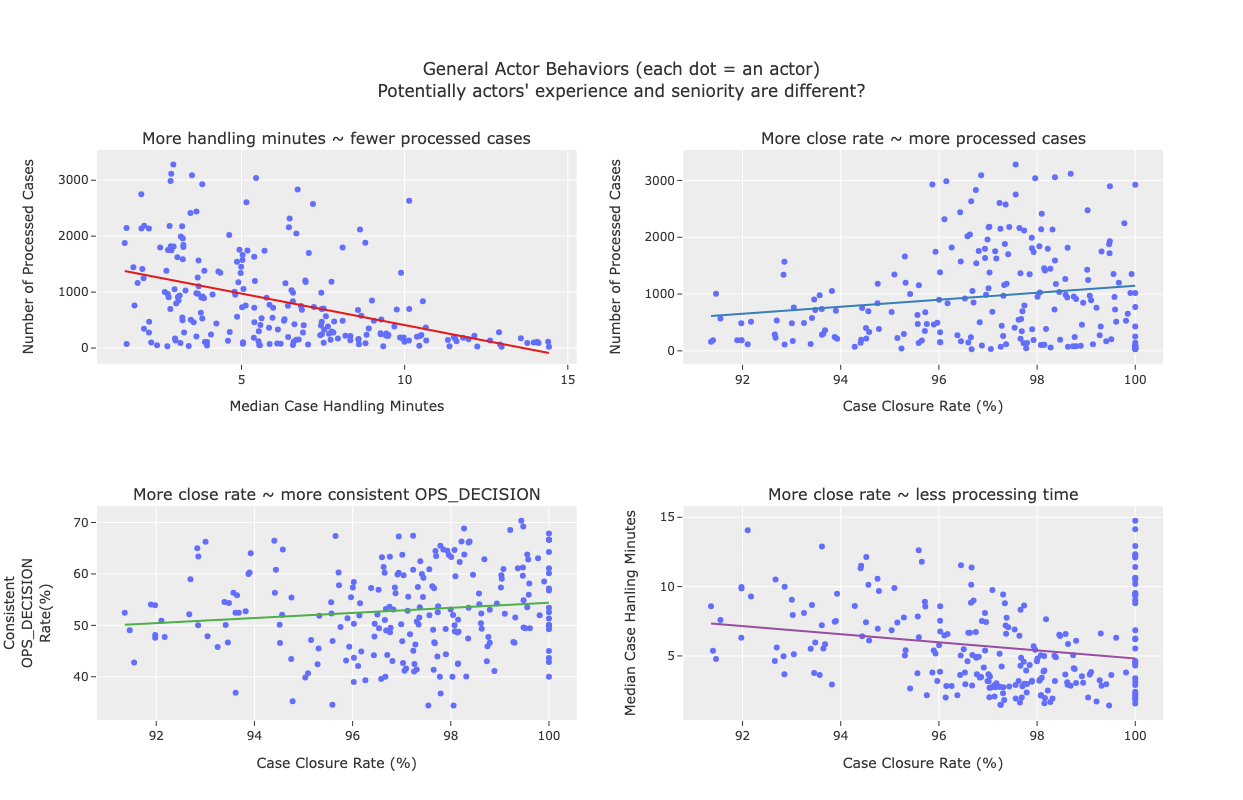

In [4]:
pairs = [("MEDIAN_HANDLING_MIN", "N_CASES"),
         ("closure_rate", "N_CASES"),
         ("closure_rate", "consistency_perc"),
         ("closure_rate", "MEDIAN_HANDLING_MIN")]

fig = make_subplots(rows=2, cols=2, shared_xaxes=False, shared_yaxes=False, 
                    subplot_titles=["More handling minutes ~ fewer processed cases",
                                    "More close rate ~ more processed cases",
                                    "More close rate ~ more consistent OPS_DECISION",
                                    "More close rate ~ less processing time"
                                   ])
print("correlation matrix")
display(agg_actor.corr())
colors = px.colors.qualitative.Set1
for i, ((x, y), color) in enumerate(zip(pairs, colors), start=1):
    row = (i-1)//2 + 1
    col = (i-1)%2 + 1
    x_iqr = np.percentile(agg_actor[x], 75) - np.percentile(agg_actor[x], 25)
    x_lower = max(np.percentile(agg_actor[x], 25) - 1.5 * x_iqr, np.percentile(agg_actor[x], 15))
    x_upper = min(np.percentile(agg_actor[x], 75) + 1.5 * x_iqr, np.percentile(agg_actor[x], 95))

    y_iqr = np.percentile(agg_actor[y], 75) - np.percentile(agg_actor[y], 25)
    y_lower = max(np.percentile(agg_actor[y], 25) - 1.5 * y_iqr, np.percentile(agg_actor[y], 15))
    y_upper = min(np.percentile(agg_actor[y], 75) + 1.5 * y_iqr, np.percentile(agg_actor[y], 95))
    
    scatter_plot_df = agg_actor[(agg_actor[x] >= x_lower) 
                                & (agg_actor[x] <= x_upper)
                                & (agg_actor[y] >= y_lower) 
                                & (agg_actor[y] <= y_upper)]
    
    scatter_plot_df["ACTOR_ID"] = scatter_plot_df["ACTOR_ID"].astype(str)
    
    scatter_plot = px.scatter(scatter_plot_df, y=y, x=x, trendline="ols")
    
    # Modify the trendline color
    trendline_trace = scatter_plot.data[1]
    trendline_trace['line']['color'] = color
    
    # Add scatter plot points
    fig.add_trace(scatter_plot.data[0], row=row, col=col)
    # Add trendline
    fig.add_trace(trendline_trace, row=row, col=col)
        # Update axis titles
    if x == "MEDIAN_HANDLING_MIN":
        xname = "Median Case Handling Minutes"
    elif x == "closure_rate": 
        xname = "Case Closure Rate (%)"
    elif x == "MEDIAN_FIRST_TOUCH_MIN":
        xname = "Median First Response Minutes"
    else:
        xname= x

    if y == "N_CASES":
        yname = "Number of Processed Cases"
    elif y == "consistency_perc": 
        yname = "Consistent<br>OPS_DECISION<br>Rate(%)"
    elif y == "MEDIAN_HANDLING_MIN":
        yname = "Median Case Hanling Minutes"
    else:
        yname= y
    
    
    fig.update_xaxes(title_text=xname, row=row, col=col)
    fig.update_yaxes(title_text=yname, row=row, col=col)

# Update layout
fig.update_layout(title="""General Actor Behaviors (each dot = an actor)<br>Potentially actors' experience and seniority are different?""",
                  height=800, showlegend=False, template='ggplot2',
                  margin=dict(t=150)
                 )

# Show plot
fig.show()

### ACTOR BEHAVIOR - TOP 30 INVIDUAL IDS (BY PROCESSED CASES)

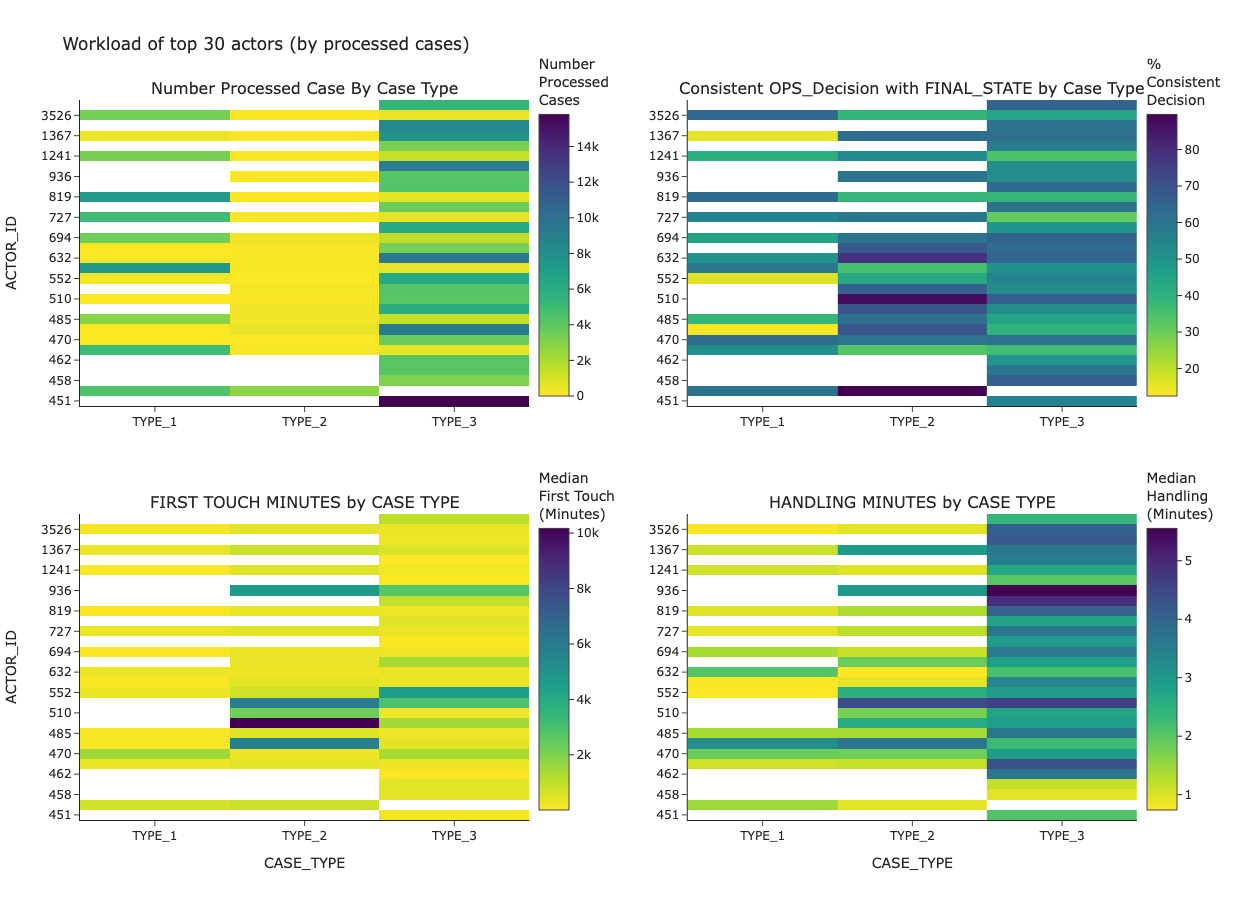

In [5]:
# Select top 30
# we only consider when Operators already processed at least 5 cases
n_top = 30
top_actor_id = agg_actor.sort_values(by="N_CASES", ascending=False)[:n_top]
top_actor_id = top_actor_id["ACTOR_ID"].unique()

df_agg_actor_type = df.groupby(["ACTOR_ID", "CASE_TYPE"]).agg({"CASE_ID": lambda x: x.nunique(),
                                                    "PROCESSING_ID": lambda x: x.nunique()}).reset_index()

heatmap_workload_type = df_agg_actor_type[df_agg_actor_type.ACTOR_ID.isin(top_actor_id)].pivot(columns='CASE_TYPE', index='ACTOR_ID', values="CASE_ID")

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Number Processed Case By Case Type",
                                    "Consistent OPS_Decision with FINAL_STATE by Case Type",
                                    "FIRST TOUCH MINUTES by CASE TYPE",
                                    "HANDLING MINUTES by CASE TYPE",
                                   ),
                    horizontal_spacing=0.15,
                    vertical_spacing=0.15
)

# Heatmap for workload by case type
fig.add_trace(go.Heatmap(
    z=heatmap_workload_type.values,
    x=heatmap_workload_type.columns.astype(str),
    y=heatmap_workload_type.index.astype(str),
    colorscale='Viridis_r',
    colorbar=dict(title='Number<br>Processed<br>Cases', len=0.5, x=0.425, y=0.825)
), row=1, col=1)

# For percentage consistent of OPS_DECISION AND FINAL_STATE
# we only consider when Operators make at least 5 decisions
heatmap_actor_decision = agg_actor_type[agg_actor_type.ACTOR_ID.isin(top_actor_id) 
                                        & (agg_actor_type.all_decision >= 5)]
heatmap_actor_decision = heatmap_actor_decision.pivot(index='ACTOR_ID', columns='CASE_TYPE', values="consistency_perc")
# Heatmap for workload by month
fig.add_trace(go.Heatmap(
    z=heatmap_actor_decision.values,
    x=heatmap_actor_decision.columns,
    y=heatmap_actor_decision.index.astype(str),
    colorscale='Viridis_r',
    colorbar=dict(title='%<br>Consistent<br>Decision', len=0.5, x=1, y=0.825)
), row=1, col=2)


# For percentage consistent of OPS_DECISION AND FINAL_STATE
# we only consider when Operators make at least 5 decisions
heatmap_actor_first_touch = agg_actor_type[agg_actor_type.ACTOR_ID.isin(top_actor_id) 
                                            & (agg_actor_type.all_decision >= 5)]
heatmap_actor_first_touch = heatmap_actor_first_touch.pivot(index='ACTOR_ID', columns='CASE_TYPE', values="MEDIAN_FIRST_TOUCH_MIN")
# Heatmap for workload by month
fig.add_trace(go.Heatmap(
    z=heatmap_actor_first_touch.values,
    x=heatmap_actor_first_touch.columns,
    y=heatmap_actor_first_touch.index.astype(str),
    colorscale='Viridis_r',
    colorbar=dict(title='Median<br>First Touch<br>(Minutes)', len=0.5, x=0.425, y=0.25)
), row=2, col=1)

heatmap_actor_handling = agg_actor_type[agg_actor_type.ACTOR_ID.isin(top_actor_id) 
                                        & (agg_actor_type.all_decision >= 5)]
heatmap_actor_handling = heatmap_actor_handling.pivot(index='ACTOR_ID', columns='CASE_TYPE', values="MEDIAN_HANDLING_MIN")
# Heatmap for workload by month
fig.add_trace(go.Heatmap(
    z=heatmap_actor_handling.values,
    x=heatmap_actor_handling.columns,
    y=heatmap_actor_handling.index.astype(str),
    colorscale='Viridis_r',
    colorbar=dict(title='Median<br>Handling<br>(Minutes)', len=0.5, x=1, y=0.25)
), row=2, col=2)



# Update layout
fig.update_layout(
    title=f'Workload of top {n_top} actors (by processed cases)',
    width=1500,
    height=900,
    template="simple_white"
)

fig.update_yaxes(title_text="ACTOR_ID", row=1, col=1)
fig.update_yaxes(title_text="ACTOR_ID", row=2, col=1)
fig.update_xaxes(title_text="CASE_TYPE", row=2, col=1)
fig.update_xaxes(title_text="CASE_TYPE", row=2, col=2)
fig.show()


### ACTOR BEHAVIOR - BOTTOM 30 INVIDUAL IDS (BY PROCESSED CASES)

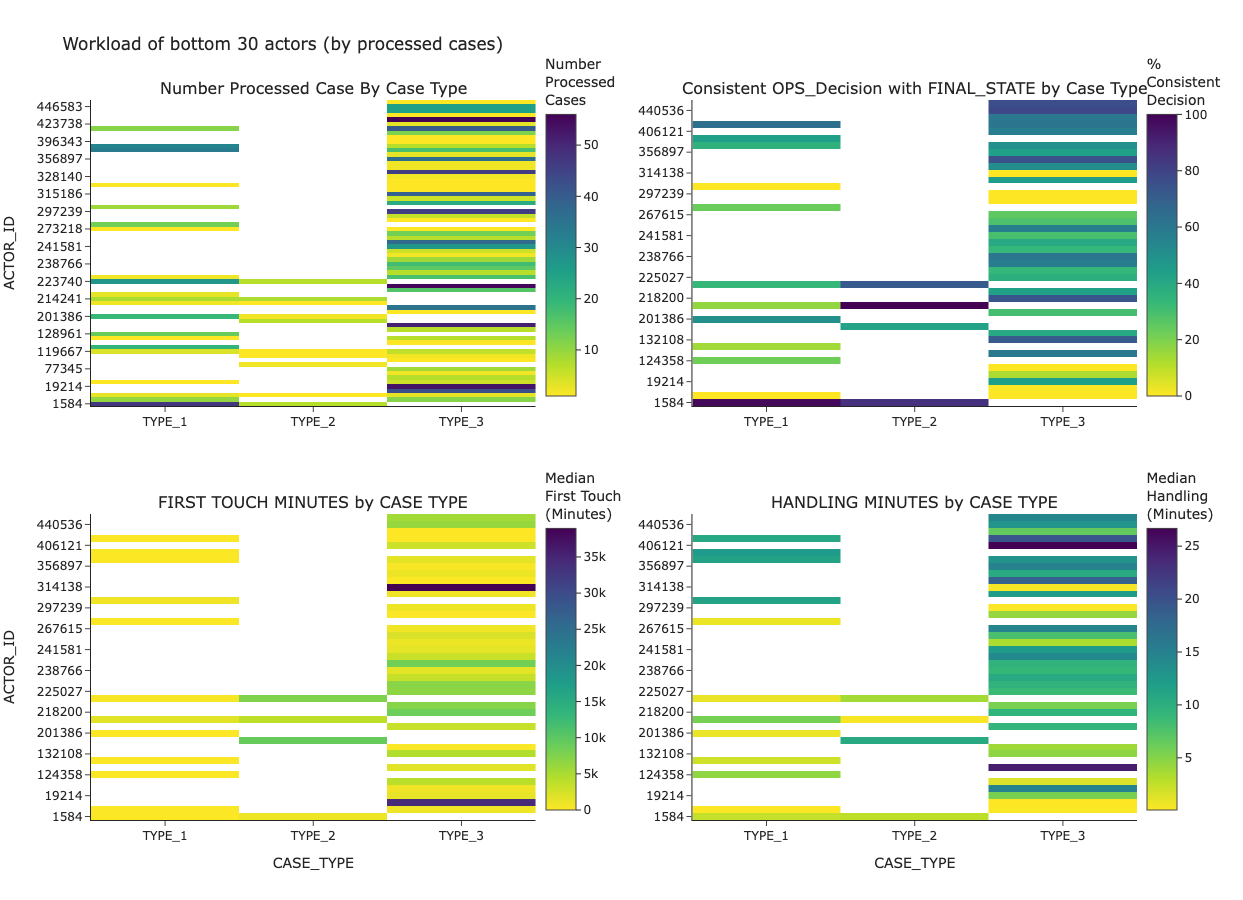

In [6]:
# Select bottom 70 actors to analyze
# we only consider when Operators already processed at least 5 cases
n_top = 70
top_actor_id = agg_actor.sort_values(by="N_CASES", ascending=True)[:n_top]
top_actor_id = top_actor_id["ACTOR_ID"].unique()

df_agg_actor_type = df.groupby(["ACTOR_ID", "CASE_TYPE"]).agg({"CASE_ID": lambda x: x.nunique(),
                                                            "PROCESSING_ID": lambda x: x.nunique()}).reset_index()

heatmap_workload_type = df_agg_actor_type[df_agg_actor_type.ACTOR_ID.isin(top_actor_id)].pivot(columns='CASE_TYPE', index='ACTOR_ID', values="CASE_ID")

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Number Processed Case By Case Type",
                                    "Consistent OPS_Decision with FINAL_STATE by Case Type",
                                    "FIRST TOUCH MINUTES by CASE TYPE",
                                    "HANDLING MINUTES by CASE TYPE",
                                   ),
                    horizontal_spacing=0.15,
                    vertical_spacing=0.15
)

# Heatmap for workload by case type
fig.add_trace(go.Heatmap(
    z=heatmap_workload_type.values,
    x=heatmap_workload_type.columns.astype(str),
    y=heatmap_workload_type.index.astype(str),
    colorscale='Viridis_r',  # You can choose any colorscale
    colorbar=dict(title='Number<br>Processed<br>Cases', len=0.5, x=0.425, y=0.825)
), row=1, col=1)

# For percentage consistent of OPS_DECISION AND FINAL_STATE
# we only consider when Operators make at least 5 decisions
heatmap_actor_decision = agg_actor_type[agg_actor_type.ACTOR_ID.isin(top_actor_id) 
                                        & (agg_actor_type.all_decision >= 5)]
heatmap_actor_decision = heatmap_actor_decision.pivot(index='ACTOR_ID', columns='CASE_TYPE', values="consistency_perc")
# Heatmap for workload by month
fig.add_trace(go.Heatmap(
    z=heatmap_actor_decision.values,
    x=heatmap_actor_decision.columns,
    y=heatmap_actor_decision.index.astype(str),
    colorscale='Viridis_r',  # You can choose any colorscale
    colorbar=dict(title='%<br>Consistent<br>Decision', len=0.5, x=1, y=0.825)
), row=1, col=2)


# For percentage consistent of OPS_DECISION AND FINAL_STATE
# we only consider when Operators make at least 5 decisions
heatmap_actor_first_touch = agg_actor_type[agg_actor_type.ACTOR_ID.isin(top_actor_id) 
                                            & (agg_actor_type.all_decision >= 5)]
heatmap_actor_first_touch = heatmap_actor_first_touch.pivot(index='ACTOR_ID', columns='CASE_TYPE', values="MEDIAN_FIRST_TOUCH_MIN")
# Heatmap for workload by month
fig.add_trace(go.Heatmap(
    z=heatmap_actor_first_touch.values,
    x=heatmap_actor_first_touch.columns,
    y=heatmap_actor_first_touch.index.astype(str),
    colorscale='Viridis_r',  # You can choose any colorscale
    colorbar=dict(title='Median<br>First Touch<br>(Minutes)', len=0.5, x=0.425, y=0.25)
), row=2, col=1)

heatmap_actor_handling = agg_actor_type[agg_actor_type.ACTOR_ID.isin(top_actor_id) 
                                       & (agg_actor_type.all_decision >= 5)]
heatmap_actor_handling = heatmap_actor_handling.pivot(index='ACTOR_ID', columns='CASE_TYPE', values="MEDIAN_HANDLING_MIN")
# Heatmap for workload by month
fig.add_trace(go.Heatmap(
    z=heatmap_actor_handling.values,
    x=heatmap_actor_handling.columns,
    y=heatmap_actor_handling.index.astype(str),
    colorscale='Viridis_r',  # You can choose any colorscale
    colorbar=dict(title='Median<br>Handling<br>(Minutes)', len=0.5, x=1, y=0.25)
), row=2, col=2)



# Update layout
fig.update_layout(
    title=f'Workload of bottom 30 actors (by processed cases)',
    width=1500,
    height=900,
    template="simple_white"
)

fig.update_yaxes(title_text="ACTOR_ID", row=1, col=1)
fig.update_yaxes(title_text="ACTOR_ID", row=2, col=1)
fig.update_xaxes(title_text="CASE_TYPE", row=2, col=1)
fig.update_xaxes(title_text="CASE_TYPE", row=2, col=2)
# fig.update_xaxes(title_text="MONTH", row=1, col=3)
fig.show()

### Performance on 2022-Jan

In [7]:
df_jan_2022 = df[(df['CASE_CREATED_TIME'] >= '2022-01-01') & (df['CASE_CREATED_TIME'] < '2022-02-01') & (df['CASE_TYPE'] == 'TYPE_3')]

# Calculate the current workload for TYPE_THREE cases in January 2022
current_workload = len(df_jan_2022)
print(f"Current workload for TYPE_THREE cases in January 2022: cases = {df_jan_2022.CASE_ID.nunique()}, actors = {df_jan_2022.ACTOR_ID.nunique()}, customers = {df_jan_2022.CUSTOMER_ID.nunique()}")
print(f"Current workload for TYPE_THREE cases in January 2022: cases per actor = {round(df_jan_2022.CASE_ID.nunique()/df_jan_2022.ACTOR_ID.nunique())}, cases per customers = {df_jan_2022.CASE_ID.nunique()/df_jan_2022.CUSTOMER_ID.nunique()}")

# Calculate the average handling time for TYPE_THREE cases in January 2022
df_jan_2022['HANDLING_TIME_START'] = pd.to_datetime(df_jan_2022['HANDLING_TIME_START'])
df_jan_2022['HANDLING_TIME_END'] = pd.to_datetime(df_jan_2022['HANDLING_TIME_END'])
df_jan_2022['HANDLING_TIME_MINUTES'] = (df_jan_2022['HANDLING_TIME_END'] - df_jan_2022['HANDLING_TIME_START']).dt.total_seconds() / 60
df_jan_2022["FIRST_TOUCH_MINUTES"] = (df_jan_2022["HANDLING_TIME_START"] - df["CASE_CREATED_TIME"]).dt.total_seconds()/3600
avg_handling_time, median_handling_time = df_jan_2022['HANDLING_TIME_MINUTES'].mean(), df_jan_2022['HANDLING_TIME_MINUTES'].median()
avg_first_touch, median_first_touch = df_jan_2022['FIRST_TOUCH_MINUTES'].mean(), df_jan_2022['FIRST_TOUCH_MINUTES'].median()
print(f"Average handling time for TYPE_THREE cases in January 2022: avg = {avg_handling_time:.1f} minutes, median = {median_handling_time:.1f} minutes")

# Calculate the closure rate for TYPE_THREE cases in January 2022
closed_cases = len(df_jan_2022[df_jan_2022['FINAL_STATE'].isin(close_state)])
closure_rate = closed_cases / current_workload * 100
print(f"Closure rate for TYPE_THREE cases in January 2022: {closure_rate:.2f}%")

# Analyze the workload distribution among actors for TYPE_THREE cases in January 2022
workload_distribution = df_jan_2022.groupby('ACTOR_ID').agg({"CASE_ID": lambda x: x.nunique()}).sort_values(by="CASE_ID", ascending=False)
print("Top 10 Workload distribution among actors for TYPE_THREE cases in January 2022:")
print(100*workload_distribution.iloc[:10]/workload_distribution.sum())

Current workload for TYPE_THREE cases in January 2022: cases = 29603, actors = 130, customers = 28449
Current workload for TYPE_THREE cases in January 2022: cases per actor = 228, cases per customers = 1.0405638159513515
Average handling time for TYPE_THREE cases in January 2022: avg = 6.2 minutes, median = 3.5 minutes
Closure rate for TYPE_THREE cases in January 2022: 97.73%
Top 10 Workload distribution among actors for TYPE_THREE cases in January 2022:
           CASE_ID
ACTOR_ID          
451       7.183172
632       5.607816
502       3.694721
1367      3.662987
478       3.388716
1047      3.273115
513       2.964843
2733      2.559104
461       2.395902
510       2.316567
